## **Generate random districts**

**Required packages**

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from scipy.ndimage import distance_transform_edt
import random
from matplotlib.colors import ListedColormap

**Loading and Rasterizing Precinct Data**

In [2]:
# =======================
# Loading data
# =======================

precinct_shapefile = 'fl_2016/fl_2016.shp'
votes_gdf = gpd.read_file(precinct_shapefile)

# calculate votes (blue = democrat, red = republican)
votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR']  # Blue votes
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB']   # Red votes

# Reproject to a Projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)

# calculate area to get pop per pixel
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area


# =======================
# Rasterizing
# =======================

# select columns to be rasterized
# (to calculate total votes per pixel)
selected_columns = ['blue', 'red']

# get coordinates
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000  # Adjust pixel size as needed (in meters)
width = int(np.ceil((maxx - minx) / pixel_size))
height = int(np.ceil((maxy - miny) / pixel_size))
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# rasterize attributes
raster_bands = []
for col in selected_columns:
    # Create shapes for rasterization with scaled values
    shapes = (
        (geom, value)
        for geom, value in zip(votes_gdf_projected.geometry, votes_gdf_projected[col])
    )
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'
    )
    raster_bands.append(raster_band)

blue_band, red_band = raster_bands

# total votes/population per pixel
population = blue_band + red_band 

# =======================
# Florida mask
# this part ignores pixels that are not within Florida
# =======================

# get the boundary of Florida state
florida_union = votes_gdf_projected.union_all()

# Ensure the union is a Polygon or MultiPolygon
if not isinstance(florida_union, (Polygon, MultiPolygon)):
    raise ValueError("Unexpected geometry type for unary_union. Expected Polygon or MultiPolygon.")

# Rasterize the Florida boundary to create a mask
florida_mask = rasterize(
    [(florida_union, 1)], # 1 is pixel is inside, 0 otherwise
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Apply the Florida mask to the population array
# Pixels outside Florida will have population = 0
population_masked = population * florida_mask

**Voronoi Districts Function**

In [3]:
def generate_voronoi_districts(population_masked, num_districts=27, random_seed=None):
    """
    Generates Voronoi-based districts within Florida based on a population raster.

    Parameters:
        population_masked (np.ndarray): 2D array representing population per pixel within Florida.
        num_districts (int): Number of districts to generate. Default is 27.
        tolerance (float): Population tolerance (unused in Voronoi, but kept for reference). Default is 50000.
        random_seed (int, optional): Seed for random number generator for reproducibility.

    Returns:
        district_map (np.ndarray): 2D array with district IDs assigned to each pixel. Pixels outside Florida are -1.
        seed_coords (np.ndarray): Array of shape (num_districts, 2) with seed pixel coordinates (row, column).
        target_pop (float): Target population per district.
    """
    # specify seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Calculate total and target population
    total_pop = population_masked.sum()
    target_pop = total_pop / num_districts
    # print("Total population within Florida:", total_pop)
    # print("Target population per district:", target_pop)

    # =======================
    # Voronoi Tesselation
    # =======================

    # get pixels within Florida
    valid_pixels = np.argwhere(population_masked > 0)
    if len(valid_pixels) < num_districts:
        raise ValueError("Not enough valid pixels to assign to districts.")

    # randomly sample 27 pixels (one for each district)
    seed_indices = random.sample(range(valid_pixels.shape[0]), num_districts)
    seed_coords = valid_pixels[seed_indices]

    # create an empty district map
    # initialize with -1 for ocean pixels (outside Florida)
    height, width = population_masked.shape
    district_map = -1 * np.ones((height, width), dtype=int)

    # assign each sampled pixel to a district
    for d_id, (r, c) in enumerate(seed_coords):
        district_map[r, c] = d_id

    # compute Voronoi Tessellation
    # Create a boolean array where seed pixels are True
    seed_mask = np.zeros((height, width), dtype=bool)
    seed_mask[seed_coords[:, 0], seed_coords[:, 1]] = True

    # find the nearest pixel to each sampled pixel
    distance, indices = distance_transform_edt(~seed_mask, return_indices=True)

    # assign each pixel to the nearest seed's district ID
    nearest_row = indices[0]
    nearest_col = indices[1]
    nearest_district = district_map[nearest_row, nearest_col]

    # update the district map for all valid pixels
    district_map[population_masked > 0] = nearest_district[population_masked > 0]

    # =======================
    # Calculate Population and Vote Percentages
    # =======================

    # Initialize lists to store data for each district
    district_ids = range(num_districts)
    total_population = []
    total_blue = []
    total_red = []
    percentage_blue = []
    percentage_red = []

    # create data frame with population and votes per district
    # ---------------------------------------

    for d_id in district_ids:
        # Create a mask for the current district
        mask = (district_map == d_id)
        
        # Calculate total population for the district
        pop = population_masked[mask].sum()
        total_population.append(pop)
        
        # Calculate total blue and red votes for the district
        blue = blue_band[mask].sum()
        red = red_band[mask].sum()
        total_blue.append(blue)
        total_red.append(red)
        
        # Calculate percentage of blue and red votes
        if pop > 0:
            percentage_blue.append((blue / pop) * 100.0)
            percentage_red.append((red / pop) * 100.0)
        else:
            percentage_blue.append(0)
            percentage_red.append(0)
    
    # ---------------------------------------

    data = {
        'District': district_ids,
        'Total Population': total_population,
        'Blue Votes': total_blue,
        'Red Votes': total_red,
        'Percentage Blue': percentage_blue,
        'Percentage Red': percentage_red
    }

    df = pd.DataFrame(data)

    # =======================
    # Plots:
    #  =======================

    #  Voronoi Districts
    # ------------------------
    district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
    colors = list(district_colors) + [(0, 0, 0, 1)]  # Adding black for ocean
    custom_cmap = ListedColormap(colors)

    # Step 2: Adjust district_map to Shift -1 to the Last Index (for black color)
    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts  # Assign -1 to black

    # Step 3: Plot the District Map
    plt.figure(figsize=(6, 6))
    im = plt.imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper',
        extent=(minx, maxx, miny, maxy)
    )
    # cbar = plt.colorbar(im, ticks=range(num_districts + 1))
    # cbar.ax.set_yticklabels([str(i) for i in range(num_districts)] + ['Outside Florida'])
    plt.title('27 Districts Generated via Voronoi Tessellation (Black = Outside Florida)')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.show()

    # Population and Votes per District
    # ------------------------

    fig, axes = plt.subplots(1, 2, figsize=(28, 7))  # 1 row, 2 columns

    # Plot 1: Total Population per District
    axes[0].bar(df['District'], df['Total Population'], color='lightgreen')
    axes[0].set_xlabel('District ID', fontsize=14)
    axes[0].set_ylabel('Total Population', fontsize=14)
    axes[0].set_title('Total Population per District', fontsize=16)
    axes[0].set_xticks(df['District'])
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Percentage of Blue vs Red Votes per District
    width = 0.6  # Width of the bars

    # Plot Blue Votes
    axes[1].bar(df['District'], df['Percentage Blue'], width, label='Blue', color='skyblue')

    # Plot Red Votes on top of Blue Votes
    axes[1].bar(df['District'], df['Percentage Red'], width, bottom=df['Percentage Blue'], label='Red', color='pink')

    axes[1].set_xlabel('District ID', fontsize=14)
    axes[1].set_ylabel('Percentage of Votes (%)', fontsize=14)
    axes[1].set_title('Percentage of Blue vs Red Votes per District', fontsize=16)
    axes[1].set_xticks(df['District'])
    axes[1].legend(fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # =======================
    
    return district_map, seed_coords, target_pop


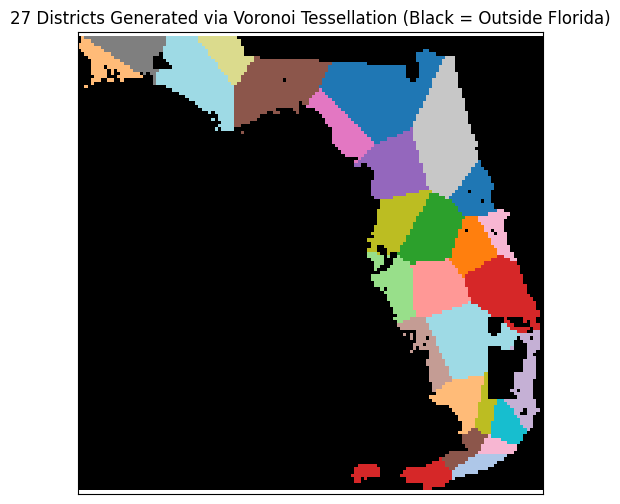

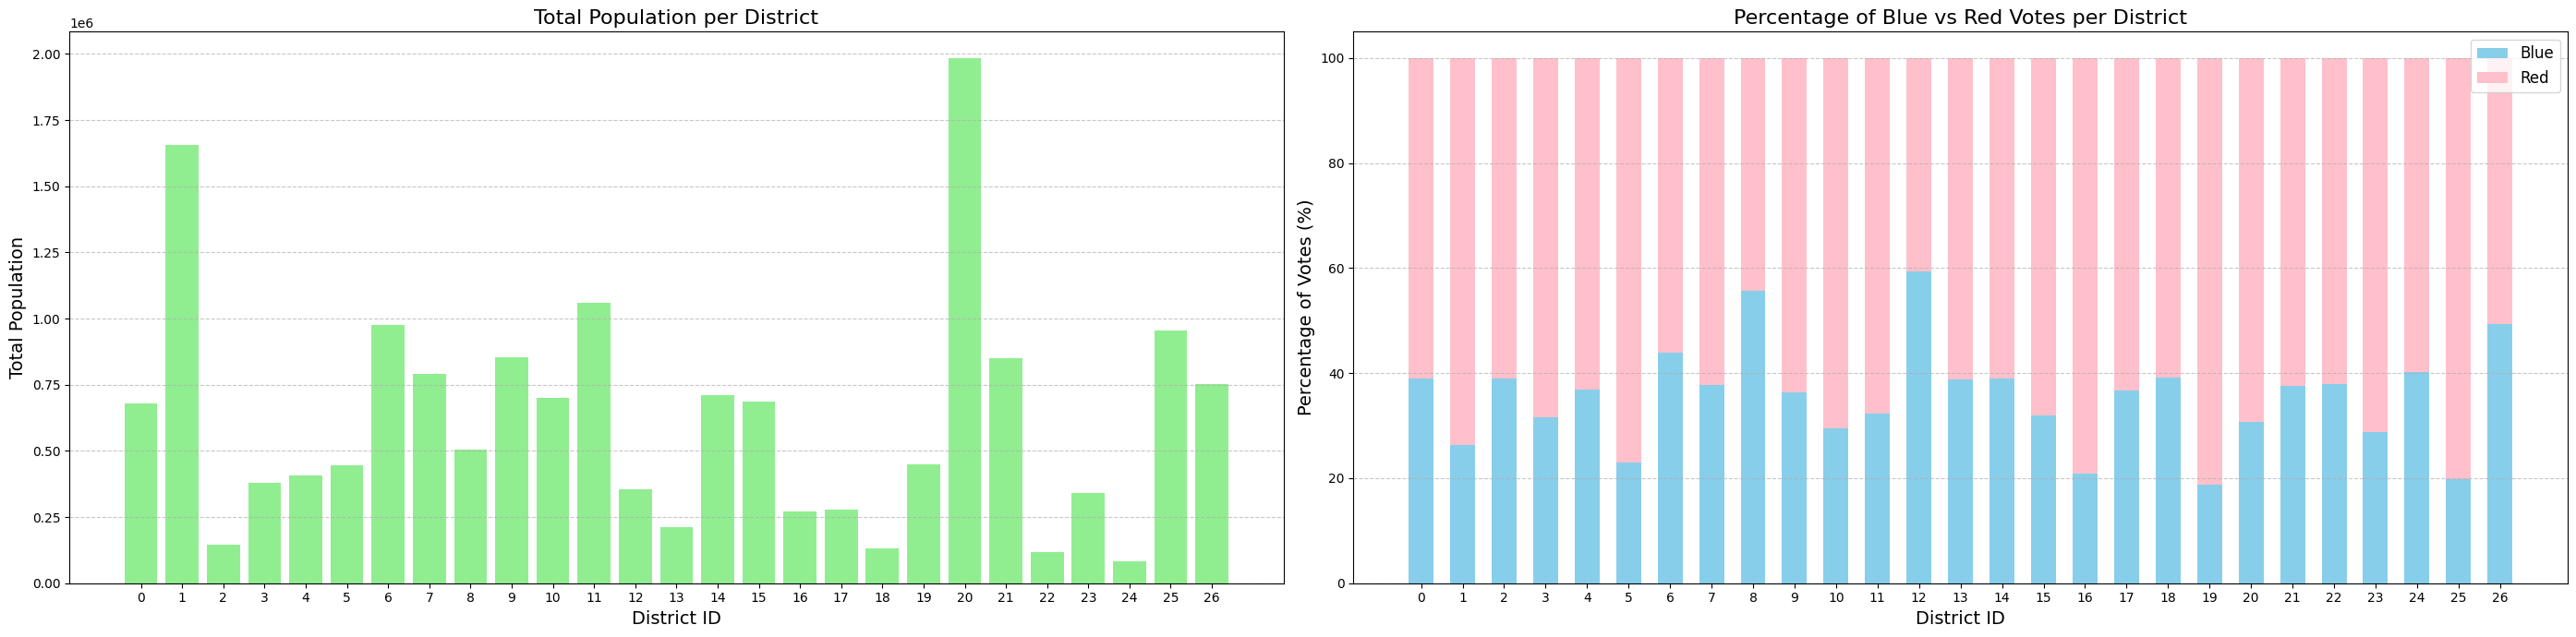

In [11]:
district_map, seed_coords, target_pop = generate_voronoi_districts(population_masked, 27)